## Step 1: Loading dataset from web page and generating .csv file


## Disease-Symptom Knowledge Database:

● Description: knowledge database of disease-symptom associations
generated by an automated method based on information in textual
discharge summaries of patients at New York Presbyterian Hospital
admitted during 2004.

● Source: Columbia University

● Dataset Link:
https://people.dbmi.columbia.edu/~friedma/Projects/DiseaseSymptomKB/index.html

In [ ]:
import pandas as pd
import requests

# Fetch the web page
url = "http://people.dbmi.columbia.edu/~friedma/Projects/DiseaseSymptomKB/index.html"
response = requests.get(url)

# Manually set encoding
response.encoding = 'ISO-8859-1'  # or try 'windows-1252'

# Now parse with pandas
dfs = pd.read_html(response.text)

# Check how many tables were parsed
print(f"Number of tables found: {len(dfs)}")

# Save the first table as CSV (or change index accordingly)
dfs[0].to_csv("disease_symptom_data.csv", index=False)

<ipython-input-20-80617b1bd6ff>:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(response.text)


Number of tables found: 1


Displaying format of dataset

In [ ]:
data = pd.read_csv("disease_symptom_data.csv")
data

,0,1,2
0,Disease,Count of Disease Occurrence,Symptom
1,UMLS:C0020538_hypertensive disease,3363,UMLS:C0008031_pain chest
2,NaN,NaN,UMLS:C0392680_shortness of breath
3,NaN,NaN,UMLS:C0012833_dizziness
4,NaN,NaN,UMLS:C0004093_asthenia
...,...,...,...
1862,NaN,NaN,UMLS:C0425251_bedridden^UMLS:C0741453_bedridden
1863,NaN,NaN,UMLS:C0242453_prostatism
1864,UMLS:C0011127_decubitus ulcer,42,UMLS:C0232257_systolic murmur
1865,NaN,NaN,UMLS:C0871754_frail


### importing required packages


In [ ]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
from collections import defaultdict

### Data Pre-processing

1. Drop rows with missing symptoms
2. Extracting Nodes and mapping disease -> symptoms

In [ ]:
# ---------- Step 1: Read CSV Data ----------
df = pd.read_csv("disease_symptom_data.csv", skiprows=1, header=None)
df.columns = ['Disease', 'Count', 'Symptom']

# Forward fill disease names and counts
df['Disease'] = df['Disease'].ffill()
df['Count'] = df['Count'].ffill()

# Drop rows with missing symptoms
df = df.dropna(subset=['Symptom'])

# ---------- Step 2: Preprocess into disease → symptoms mapping ----------
disease_symptoms = {}

for _, row in df.iterrows():
    disease = row['Disease'].split("_")[-1].strip()
    symptoms = [s.strip().split("_")[-1] for s in str(row['Symptom']).split("^")]
    if disease not in disease_symptoms:
        disease_symptoms[disease] = []
    disease_symptoms[disease].extend(symptoms)

### Building Hetrogeneous graph


**Two types of nodes:**

    ● Disease nodes (e.g., "Pneumonia", "Diabetes Mellitus")
    ● Symptom nodes (e.g., "Cough", "Fever", "Blurred Vision")

**Edges (Interactions):**

  ● **Symptom-Symptom Edge (same-type)** –A symptom-symptom edge connects two symptom nodes if they co-occur in at least 3 disease. ( i.e Minimum co-occurrence to connect symptoms)

  ● **Disease-Symptom Edge (cross-type)** – A disease-symptom edge
  connects a disease node to a symptom node if the symptom
  is known to be associated with that disease.

  ● **Disease-Disease Edge (same-type)** – A disease-disease edge connects two
  disease nodes if they share 25% common symptoms.
        
        Jaccard Similarity:

                 Jaccard(D1 ,D2 )=∣S(D1 )∪S(D2 )∣/∣S(D1 )∩S(D2 )∣

In [ ]:
# ---------- Step 3: Build heterogeneous graph ----------
G = nx.Graph()
symptom_pair_counts = defaultdict(int)
threshold = 3  # Minimum co-occurrence to connect symptoms

# First pass: collect co-occurrence counts
for symptoms in disease_symptoms.values():
    for s1, s2 in combinations(set(symptoms), 2):
        pair = tuple(sorted((s1, s2)))
        symptom_pair_counts[pair] += 1

# Add disease and symptom nodes + edges
for disease, symptoms in disease_symptoms.items():
  if disease not in ('Disease'):
    G.add_node(disease, type='disease')
    for symptom in symptoms:
        G.add_node(symptom, type='symptom')
        G.add_edge(symptom, disease, relation='symptom-disease')

# Add symptom-symptom edges based on threshold
for (s1, s2), count in symptom_pair_counts.items():
    if count >= threshold:
        G.add_edge(s1, s2, relation='symptom-symptom', weight=count)

# Add disease-disease similarity edges (Jaccard index ≥ 0.25)
disease_list = list(disease_symptoms.keys())
for i in range(len(disease_list)):
    for j in range(i + 1, len(disease_list)):
        d1, d2 = disease_list[i], disease_list[j]
        s1, s2 = set(disease_symptoms[d1]), set(disease_symptoms[d2])
        jaccard = len(s1 & s2) / len(s1 | s2)
        if jaccard >= 0.25:
            G.add_edge(d1, d2, relation='disease-disease', weight=round(jaccard, 2))


### Visualizing the Hetrogeneous graph in circular layout


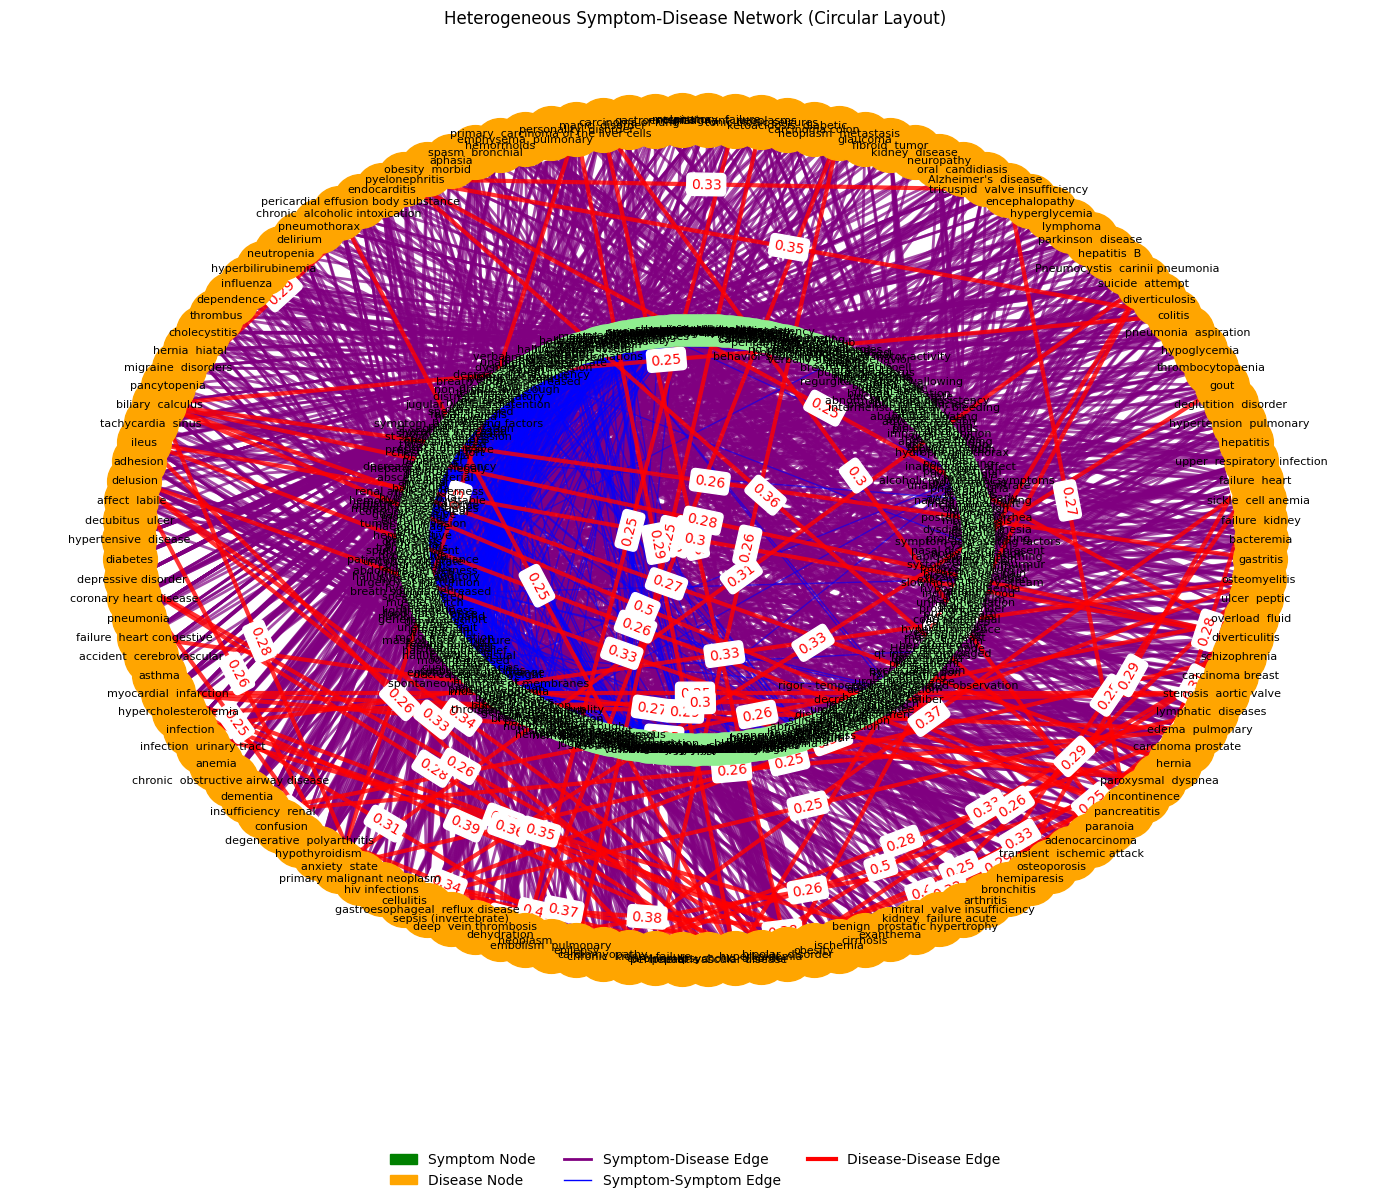

In [ ]:
# ---------- Step 4: Draw the network (Circular Layout) ----------
plt.figure(figsize=(14, 12))

# Define positions based on node types
symptom_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'symptom']
disease_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'disease']

# Arrange disease nodes in outer circle, symptom nodes in inner circle
shell_pos = nx.shell_layout(G, nlist=[symptom_nodes, disease_nodes])

# Draw nodes
nx.draw_networkx_nodes(G, shell_pos, nodelist=symptom_nodes, node_color='lightgreen', node_size=500, label='Symptom')
nx.draw_networkx_nodes(G, shell_pos, nodelist=disease_nodes, node_color='orange', node_size=1500, label='Disease')

# Draw edges by type
edges_sd = [(u, v) for u, v, d in G.edges(data=True) if d['relation'] == 'symptom-disease']
edges_ss = [(u, v) for u, v, d in G.edges(data=True) if d['relation'] == 'symptom-symptom']
edges_dd = [(u, v) for u, v, d in G.edges(data=True) if d['relation'] == 'disease-disease']

nx.draw_networkx_edges(G, shell_pos, edgelist=edges_sd, edge_color='purple', width=2, alpha=0.7)
nx.draw_networkx_edges(G, shell_pos, edgelist=edges_ss, edge_color='blue', width=1, alpha=0.6)
nx.draw_networkx_edges(G, shell_pos, edgelist=edges_dd, edge_color='red', width=3, alpha=0.8)

# Draw labels
nx.draw_networkx_labels(G, shell_pos, font_size=8)

# Edge labels for disease-disease weights
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True) if d['relation'] == 'disease-disease'}
nx.draw_networkx_edge_labels(G, shell_pos, edge_labels=edge_labels, font_size=10, font_color='red')

# Legend
symptom_patch = mpatches.Circle((0, 0), radius=5, color='green', label='Symptom Node')
disease_patch = mpatches.Circle((0, 0), radius=5, color='orange', label='Disease Node')
sd_edge = mlines.Line2D([], [], color='purple', linewidth=2, label='Symptom-Disease Edge')
ss_edge = mlines.Line2D([], [], color='blue', linewidth=1, label='Symptom-Symptom Edge')
dd_edge = mlines.Line2D([], [], color='red', linewidth=3, label='Disease-Disease Edge')

plt.legend(handles=[symptom_patch, disease_patch, sd_edge, ss_edge, dd_edge],
           loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

# Final plot formatting
plt.title("Heterogeneous Symptom-Disease Network (Circular Layout)")
plt.axis('off')
plt.tight_layout()
plt.show()


### Heterogeneous Symptom-Disease Network using a circular layout
**Node Types:**

    Green Nodes: Represent symptoms.

    Orange Nodes: Represent diseases.

**Edge Types:**

    Purple Edges: Connect symptom nodes to disease nodes, signifying that a symptom is associated with a specific disease.

    Blue Edges: Connect symptom nodes to symptom nodes, indicating relationships between symptoms if symptoms co-occurrences atleast Threshold(3) Diseases.

    Red Edges: Connect disease nodes to disease nodes, indicating some form of relationship between diseases—possibly if they share atleast 25% common symptoms.

**Edge Weights (on red edges):**
Red edges are annotated with numerical values (e.g., 0.25, 0.33, 0.5) which likely represent the strength or weight of connection between two diseases—possibly a similarity or co-occurrence metric.

**Layout:**
The layout is circular, with:

    Symptom nodes (green) placed in the inner circle.

    Disease nodes (orange) placed on the outer circle.

### Computing Basic Network Metrics

In [ ]:
# ---- Step 3: Compute Basic Network Metrics ----
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
symptom_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'symptom']
disease_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'disease']
symptom_edges = [e for e in G.edges(data=True) if e[2]['relation'] == 'symptom-symptom']
disease_symptom_edges = [e for e in G.edges(data=True) if e[2]['relation'] == 'symptom-disease']
disease_disease_edges = [e for e in G.edges(data=True) if e[2]['relation'] == 'disease-disease']

print("Total Nodes:", num_nodes)
print("Symptoms:", len(symptom_nodes))
print("Diseases:", len(disease_nodes))
print("Total Edges:", num_edges)
print("Symptom-Symptom Edges:", len(symptom_edges))
print("Disease-Symptom Edges:", len(disease_symptom_edges))
print("Disease-Disease Edges:", len(disease_disease_edges))

avg_degree = sum(dict(G.degree()).values()) / num_nodes
density = nx.density(G)
connected_components = nx.number_connected_components(G)

print("\nAverage Node Degree:", round(avg_degree, 2))
print("Network Density:", round(density, 4))
print("Connected Components:", connected_components)

# ---- Step 4: Centrality (Highlight Critical Symptoms) ----
degree_centrality = nx.degree_centrality(G)

# Add centrality to node attributes
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# ---- Step 5: Export for Gephi / Cytoscape (.gexf format) ----
nx.write_gexf(G, "symptom_disease_network.gexf")
print("\n✅ Network exported to 'symptom_disease_network.gexf' for Gephi/Cytoscape.")

Total Nodes: 580
Symptoms: 446
Diseases: 134
Total Edges: 2865
Symptom-Symptom Edges: 874
Disease-Symptom Edges: 1894
Disease-Disease Edges: 97

Average Node Degree: 9.88
Network Density: 0.0171
Connected Components: 1

✅ Network exported to 'symptom_disease_network.gexf' for Gephi/Cytoscape.


### Computing Centrality Measures
1. Degree Centrality
2. Betweeness Centrality
3. closeness Centrality
4. Eigen vector Centrality


In [ ]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, weight=None)
closeness_centrality = nx.closeness_centrality(G)
try:
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, weight=None)
except nx.PowerIterationFailedConvergence:
    eigenvector_centrality = {n: 0.0 for n in G.nodes()}
weighted_degree = dict(G.degree(weight='weight'))


# ---- Identify Node Types ----
symptom_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'symptom']
disease_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'disease']

# ---- Step 4 (Modified): Helper function for ranking and printing TOP OR BOTTOM ----
def print_extreme_k_nodes(centrality_dict, node_list, node_type_label, centrality_label, k=5, top=True):
    direction = "Top" if top else "Bottom"
    print(f"\n🔹 {direction}-{k} {node_type_label} by {centrality_label} Centrality (Overall Graph):")

    filtered_centrality = {node: score for node, score in centrality_dict.items() if node in node_list}
    # Sort ascending for bottom-k, descending for top-k
    sorted_nodes = sorted(
        filtered_centrality.items(),
        key=lambda x: x[1], reverse=top
    )
    for i, (node, score) in enumerate(sorted_nodes[:k], start=1):
        print(f"{i:2d}. {node:<30} {score:.4f}")
    return sorted_nodes[:k]
top_k = 2
bottom_k = 2 # Or any other number you're interested in

print("\n\n--- Centrality Measures (Calculated on the Full Graph) ---")
# --- For SYMPTOMS ---
print("\n--- For SYMPTOMS (top k Nodes) ---")
bottom_degree_symptoms = print_extreme_k_nodes(degree_centrality, symptom_nodes, "Symptoms", "Degree", top_k)
bottom_betweenness_symptoms = print_extreme_k_nodes(betweenness_centrality, symptom_nodes, "Symptoms", "Betweenness", top_k)
bottom_closeness_symptoms = print_extreme_k_nodes(closeness_centrality, symptom_nodes, "Symptoms", "Closeness", top_k)
bottom_eigenvector_symptoms = print_extreme_k_nodes(eigenvector_centrality, symptom_nodes, "Symptoms", "Eigenvector", top_k)



print("\n--- For SYMPTOMS (Bottom k Nodes) ---")
bottom_degree_symptoms = print_extreme_k_nodes(degree_centrality, symptom_nodes, "Symptoms", "Degree", bottom_k, top=False)
bottom_betweenness_symptoms = print_extreme_k_nodes(betweenness_centrality, symptom_nodes, "Symptoms", "Betweenness", bottom_k, top=False)
bottom_closeness_symptoms = print_extreme_k_nodes(closeness_centrality, symptom_nodes, "Symptoms", "Closeness", bottom_k, top=False)
bottom_eigenvector_symptoms = print_extreme_k_nodes(eigenvector_centrality, symptom_nodes, "Symptoms", "Eigenvector", bottom_k, top=False)


# --- For DISEASES ---
print("\n--- For DISEASES(top k Nodes ) ---")
bottom_degree_diseases = print_extreme_k_nodes(degree_centrality, disease_nodes, "Diseases", "Degree", top_k)
bottom_betweenness_diseases = print_extreme_k_nodes(betweenness_centrality, disease_nodes, "Diseases", "Betweenness", top_k)
bottom_closeness_diseases = print_extreme_k_nodes(closeness_centrality, disease_nodes, "Diseases", "Closeness", top_k)
bottom_eigenvector_diseases = print_extreme_k_nodes(eigenvector_centrality, disease_nodes, "Diseases", "Eigenvector", top_k)

print("\n--- For DISEASES(Bottom k Nodes ) ---")
bottom_degree_diseases = print_extreme_k_nodes(degree_centrality, disease_nodes, "Diseases", "Degree", bottom_k, top=False)
bottom_betweenness_diseases = print_extreme_k_nodes(betweenness_centrality, disease_nodes, "Diseases", "Betweenness", bottom_k, top=False)
bottom_closeness_diseases = print_extreme_k_nodes(closeness_centrality, disease_nodes, "Diseases", "Closeness", bottom_k, top=False)
bottom_eigenvector_diseases = print_extreme_k_nodes(eigenvector_centrality, disease_nodes, "Diseases", "Eigenvector", bottom_k, top=False)




--- Centrality Measures (Calculated on the Full Graph) ---

--- For SYMPTOMS (top k Nodes) ---

🔹 Top-2 Symptoms by Degree Centrality (Overall Graph):
 1. shortness of breath            0.1779
 2. pain                           0.1623

🔹 Top-2 Symptoms by Betweenness Centrality (Overall Graph):
 1. pain                           0.1085
 2. fever                          0.1065

🔹 Top-2 Symptoms by Closeness Centrality (Overall Graph):
 1. pain                           0.4588
 2. fever                          0.4573

🔹 Top-2 Symptoms by Eigenvector Centrality (Overall Graph):
 1. shortness of breath            0.2475
 2. fever                          0.2247

--- For SYMPTOMS (Bottom k Nodes) ---

🔹 Bottom-2 Symptoms by Degree Centrality (Overall Graph):
 1. mental  status changes         0.0017
 2. feeling  suicidal              0.0017

🔹 Bottom-2 Symptoms by Betweenness Centrality (Overall Graph):
 1. pain  chest                    0.0000
 2. sweating  increased            0.0000


### Analysis on these top K centrality measures
**"Pain,"** **"fever,"** and **"shortness of breath"** are very common, general symptoms associated with a wide array of diseases and conditions.

##Symptoms:

**shortness of breath** - degree (14) and its adj nodes having high degree

**pain** - degree -(95)  with disease(41) and symptoms(54)

**fever** - degree -(90) with disease-(34) and symptoms (56)

##Diseases:

**Bi polar disorder** - degree (37)

**psychotic  disorder** - degree (35)

**depressive disorder**- degree(25)

**pneumonia** - degree(21)

**chronic  kidney failure** - degree(24)

**High Degree:** Because they are general, they will naturally be linked to many different diseases and potentially co-occur with many other symptoms, giving them a high degree.

##  Impact on Other Measures:
**Betweenness:**  "pain" links to 41 diseases, and "fatigue" links to 12 different diseases, a path from a unique symptom of disease A (where pain is present) to a unique symptom of disease B (where pain is also present) might go through "pain."

**Closeness:** Having many direct connections (high degree) inherently reduces the average distance to all other nodes. If you can reach many nodes in 1 step, your average path length to all nodes will be lower, leading to high closeness.

**Eigenvector:** If these general symptoms are connected to many diseases, and some of those diseases are also "important".

In [ ]:

# ---- Step 6: Centrality in Subgraphs ----
top_k = 2
bottom_k = 2

# 6a. Symptom-Symptom Network
symptom_symptom_edges = [(u, v, d) for u, v, d in G.edges(data=True) if G.nodes[u].get('type') == 'symptom' and G.nodes[v].get('type') == 'symptom']
G_symptoms_only = nx.Graph()
G_symptoms_only.add_nodes_from(symptom_nodes) # Add all symptom nodes first
# For each symptom node, copy its attributes from G
for sn in symptom_nodes:
    G_symptoms_only.nodes[sn].update(G.nodes[sn])
G_symptoms_only.add_edges_from(symptom_symptom_edges)

if G_symptoms_only.number_of_nodes() > 0 and G_symptoms_only.number_of_edges() > 0:
    print("\n\n--- Centrality Measures in Symptom-Symptom Network Only ---")
    # Recalculate centralities ONLY on this subgraph
    # Check if G_symptoms_only is connected, as closeness/betweenness assume connectivity
    if nx.is_connected(G_symptoms_only):
        s_degree_c = nx.degree_centrality(G_symptoms_only)
        s_betweenness_c = nx.betweenness_centrality(G_symptoms_only, normalized=True)
        s_closeness_c = nx.closeness_centrality(G_symptoms_only)
        try:
            s_eigenvector_c = nx.eigenvector_centrality(G_symptoms_only, max_iter=1000)
        except nx.PowerIterationFailedConvergence:
            s_eigenvector_c = {n:0.0 for n in G_symptoms_only.nodes()}


        print("\n-----------Top k Nodes----------------")
        print_extreme_k_nodes(s_degree_c, list(G_symptoms_only.nodes()), "Symptoms", "Degree (in Symptom-Net)", top_k)
        print_extreme_k_nodes(s_betweenness_c, list(G_symptoms_only.nodes()), "Symptoms", "Betweenness (in Symptom-Net)", top_k)
        print_extreme_k_nodes(s_closeness_c, list(G_symptoms_only.nodes()), "Symptoms", "Closeness (in Symptom-Net)", top_k)
        print_extreme_k_nodes(s_eigenvector_c, list(G_symptoms_only.nodes()), "Symptoms", "Eigenvector (in Symptom-Net)", top_k)
        print("\n-----------Bottom k Nodes----------------")

        print_extreme_k_nodes(s_degree_c, list(G_symptoms_only.nodes()), "Symptoms", "Degree (in Symptom-Net)", top_k,top=False)
        print_extreme_k_nodes(s_betweenness_c, list(G_symptoms_only.nodes()), "Symptoms", "Betweenness (in Symptom-Net)", top_k,top=False)
        print_extreme_k_nodes(s_closeness_c, list(G_symptoms_only.nodes()), "Symptoms", "Closeness (in Symptom-Net)", top_k,top=False)
        print_extreme_k_nodes(s_eigenvector_c, list(G_symptoms_only.nodes()), "Symptoms", "Eigenvector (in Symptom-Net)", top_k,top=False)

        print("\n--- Interpretation of Symptom-Symptom Network Centralities ---")
        print("High Degree (Symptom-Net): Symptom co-occurs with many OTHER symptoms.")
        print("High Betweenness (Symptom-Net): Symptom bridges different clusters of CO-OCCURRING symptoms.")
        print("High Closeness (Symptom-Net): Symptom is 'central' within the landscape of symptom co-occurrences.")
        print("High Eigenvector (Symptom-Net): Symptom co-occurs with other symptoms that themselves co-occur frequently.")
    else:
        print("Symptom-only subgraph is not connected. Closeness and Betweenness centrality might be less meaningful or split by component.")
        # You could iterate over components of G_symptoms_only if needed
        s_degree_c = nx.degree_centrality(G_symptoms_only)
        print_extreme_k_nodes(s_degree_c, list(G_symptoms_only.nodes()), "Symptoms", "Degree (in Symptom-Net)", top_k)
        print_extreme_k_nodes(s_degree_c, list(G_symptoms_only.nodes()), "Symptoms", "Degree (in Symptom-Net)", top_k,top=False)

else:
    print("\n\n--- Symptom-Symptom Network is empty or has no edges ---")


# 6b. Disease-Disease Network
disease_disease_edges = [(u, v, d) for u, v, d in G.edges(data=True) if G.nodes[u].get('type') == 'disease' and G.nodes[v].get('type') == 'disease']
G_diseases_only = nx.Graph()
G_diseases_only.add_nodes_from(disease_nodes)
for dn in disease_nodes:
    G_diseases_only.nodes[dn].update(G.nodes[dn])
G_diseases_only.add_edges_from(disease_disease_edges)


if G_diseases_only.number_of_nodes() > 0 and G_diseases_only.number_of_edges() > 0:
    print("\n\n--- Centrality Measures in Disease-Disease Network Only ---")
    if nx.is_connected(G_diseases_only):
        d_degree_c = nx.degree_centrality(G_diseases_only)
        d_betweenness_c = nx.betweenness_centrality(G_diseases_only, normalized=True)
        d_closeness_c = nx.closeness_centrality(G_diseases_only)
        try:
            d_eigenvector_c = nx.eigenvector_centrality(G_diseases_only, max_iter=1000)
        except nx.PowerIterationFailedConvergence:
            d_eigenvector_c = {n:0.0 for n in G_diseases_only.nodes()}

        print_extreme_k_nodes(d_degree_c, list(G_diseases_only.nodes()), "Diseases", "Degree (in Disease-Net)", top_k)
        print_extreme_k_nodes(d_betweenness_c, list(G_diseases_only.nodes()), "Diseases", "Betweenness (in Disease-Net)", top_k)
        print_extreme_k_nodes(d_closen_c, list(G_diseases_only.nodes()), "Diseases", "Closeness (in Disease-Net)", top_k)
        print_extreme_k_nodes(d_eigenvector_c, list(G_diseases_only.nodes()), "Diseases", "Eigenvector (in Disease-Net)", top_k)

        print("\n-----------Bottom k Nodes----------------")
        print_extreme_k_nodes(d_degree_c, list(G_diseases_only.nodes()), "Diseases", "Degree (in Disease-Net)", top_k,top=False)
        print_extreme_k_nodes(d_betweenness_c, list(G_diseases_only.nodes()), "Diseases", "Betweenness (in Disease-Net)", top_k,top=False)
        print_extreme_k_nodes(d_closen_c, list(G_diseases_only.nodes()), "Diseases", "Closeness (in Disease-Net)", top_k,top=False)
        print_extreme_k_nodes(d_eigenvector_c, list(G_diseases_only.nodes()), "Diseases", "Eigenvector (in Disease-Net)", top_k,top=False)


        print("\n--- Interpretation of Disease-Disease Network Centralities ---")
        print("High Degree (Disease-Net): Disease is similar (high Jaccard) to many OTHER diseases.")
        print("High Betweenness (Disease-Net): Disease bridges different clusters of SIMILAR diseases.")
        print("High Closeness (Disease-Net): Disease is 'central' within the landscape of disease similarities.")
        print("High Eigenvector (Disease-Net): Disease is similar to other diseases that themselves are highly similar to others.")
    else:
        print("Disease-only subgraph is not connected. Closeness and Betweenness centrality might be less meaningful or split by component.")
        d_degree_c = nx.degree_centrality(G_diseases_only)
        print_extreme_k_nodes(d_degree_c, list(G_diseases_only.nodes()), "Diseases", "Degree (in Disease-Net)", top_k)
        print_extreme_k_nodes(d_degree_c, list(G_diseases_only.nodes()), "Diseases", "Degree (in Disease-Net)", top_k,top=False)

else:
    print("\n\n--- Disease-Disease Network is empty or has no edges ---")



--- Centrality Measures in Symptom-Symptom Network Only ---
Symptom-only subgraph is not connected. Closeness and Betweenness centrality might be less meaningful or split by component.

🔹 Top-2 Symptoms by Degree (in Symptom-Net) Centrality (Overall Graph):
 1. shortness of breath            0.1416
 2. fever                          0.1236

🔹 Bottom-2 Symptoms by Degree (in Symptom-Net) Centrality (Overall Graph):
 1. angina  pectoris               0.0000
 2. pressure  chest                0.0000


--- Centrality Measures in Disease-Disease Network Only ---
Disease-only subgraph is not connected. Closeness and Betweenness centrality might be less meaningful or split by component.

🔹 Top-2 Diseases by Degree (in Disease-Net) Centrality (Overall Graph):
 1. psychotic  disorder            0.0677
 2. bipolar  disorder              0.0602

🔹 Bottom-2 Diseases by Degree (in Disease-Net) Centrality (Overall Graph):
 1. accident  cerebrovascular      0.0000
 2. infection  urinary tract      

## Analysis of Centralities Measures in sub - networks

**1. symptoms -symptoms network**

Top 2:

shortness of breath - degree(14) but its neighbours(sum-of-neigb-deg=100)

fever - degree symptoms (56)

Bottom 2:

pressure chest - degree(2) in complete network but 0 in symptom's network

angina  pectoris - degree(2) in complete network but 0 in symptom's network



**2. disease-disease network**

Top 2:

psychotic  disorder - degree (10) disease network

bipolar  disorder - degree (9) disease network

Bottom 2:

Here disease-disease network there are many individual disease nodes so, choosen last 2 diseases

accident  cerebrovascular - degree (0) disease network

infection  urinary tract  - degree (0) disease network   


## Community Detection by using :

1. Louvain Algorithm

2. Spectral Clustering

In [ ]:
import networkx.algorithms.community as nx_comm
# For Spectral Clustering, scikit-learn is standard
from sklearn.cluster import SpectralClustering
import numpy as np # For adjacency matrix for Spectral


Running Louvain Algorithm...


--- Communities found by Louvain ---
Number of communities found: 8

Community 0 (Size: 184):
  Symptoms (135): pain, fever, pain abdominal, diarrhea, chill...
  Diseases (49): carcinoma prostate, chronic  kidney failure, diverticulitis, carcinoma, anemia...
  Potential Theme: (Needs manual inspection of members)

Community 1 (Size: 78):
  Symptoms (64): agitation, hallucinations auditory, suicidal, tremor, worry...
  Diseases (14): bipolar  disorder, psychotic  disorder, anxiety  state, suicide  attempt, depressive disorder...
  Potential Theme: (Needs manual inspection of members)

Community 2 (Size: 13):
  Symptoms (11): non-productive  cough, distress  respiratory, pleuritic  pain, productive  cough, chest  tightness...
  Diseases (2): pneumonia, asthma
  Potential Theme: (Needs manual inspection of members)

Community 3 (Size: 12):
  Symptoms (10): extreme exhaustion, enuresis, hepatosplenomegaly, green sputum, pain back...
  Diseases (2): influenza

<ipython-input-30-7aaa9031760c>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_communities)) # 'viridis', 'tab20', 'rainbow'


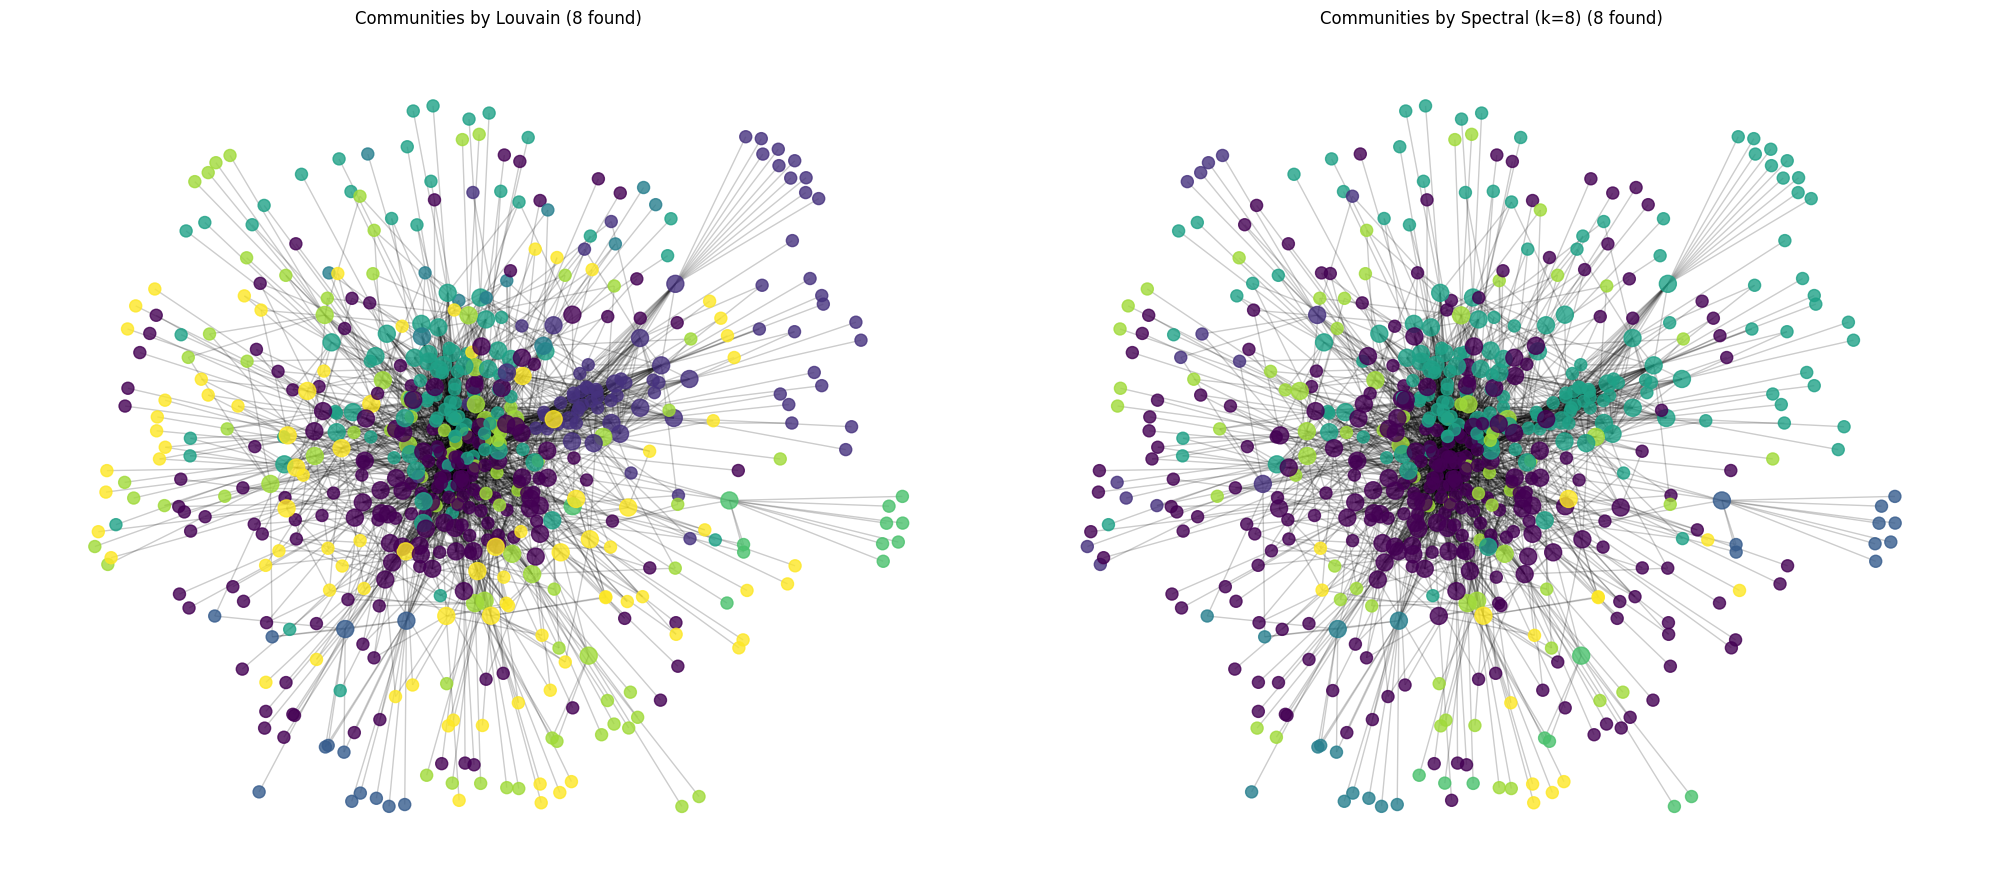

In [ ]:

# ---- Helper function to analyze and print community details ----
def analyze_and_print_communities(graph, communities_dict, algorithm_name, top_n_members=5):
    print(f"\n\n--- Communities found by {algorithm_name} ---")
    num_communities = len(set(communities_dict.values()))
    print(f"Number of communities found: {num_communities}")

    # Group nodes by community ID
    community_groups = defaultdict(list)
    for node, comm_id in communities_dict.items():
        community_groups[comm_id].append(node)

    for comm_id, members in community_groups.items():
        print(f"\nCommunity {comm_id} (Size: {len(members)}):")
        symptoms_in_comm = [m for m in members if graph.nodes[m].get('type') == 'symptom']
        diseases_in_comm = [m for m in members if graph.nodes[m].get('type') == 'disease']

        print(f"  Symptoms ({len(symptoms_in_comm)}): ", end="")
        if symptoms_in_comm:
            # Sort symptoms by degree within the community (or overall degree as a proxy)
            symptoms_sorted = sorted(symptoms_in_comm, key=lambda s: graph.degree(s, weight='weight'), reverse=True)
            print(f"{', '.join(symptoms_sorted[:top_n_members])}{'...' if len(symptoms_sorted) > top_n_members else ''}")
        else:
            print("None")

        print(f"  Diseases ({len(diseases_in_comm)}): ", end="")
        if diseases_in_comm:
            diseases_sorted = sorted(diseases_in_comm, key=lambda d: graph.degree(d, weight='weight'), reverse=True)
            print(f"{', '.join(diseases_sorted[:top_n_members])}{'...' if len(diseases_sorted) > top_n_members else ''}")
        else:
            print("None")

        # Medical Meaningfulness (Subjective - based on manual inspection)
        # Example:
        if any(s in symptoms_in_comm for s in ['Cough', 'Fever', 'Sore Throat']) and \
           any(d in diseases_in_comm for d in ['Flu', 'Common Cold', 'Pneumonia']):
            print("  Potential Theme: Respiratory Illnesses")
        elif any(s in symptoms_in_comm for s in ['Nausea', 'Vomiting', 'Stomach Pain']) and \
             any(d in diseases_in_comm for d in ['Gastritis', 'Food Poisoning', 'IBS']):
            print("  Potential Theme: Gastrointestinal Issues")
        elif any(s in symptoms_in_comm for s in ['Headache']) and \
             any(d in diseases_in_comm for d in ['Migraine', 'Tension Headache']):
            print("  Potential Theme: Headache Disorders")
        else:
            print("  Potential Theme: (Needs manual inspection of members)")
    return community_groups

# ---- Helper function for visualization ----
def visualize_communities(graph, communities_dict, algorithm_name, ax):
    pos = nx.spring_layout(graph, seed=42, k=0.5 / (graph.number_of_nodes()**0.5) if graph.number_of_nodes() > 0 else 0.5)

    # Create a color map for communities
    unique_communities = sorted(list(set(communities_dict.values())))
    colors = plt.cm.get_cmap('viridis', len(unique_communities)) # 'viridis', 'tab20', 'rainbow'
    node_colors = [colors(unique_communities.index(communities_dict[node])) for node in graph.nodes()]

    node_sizes = [300 if graph.nodes[node].get('type') == 'disease' else 150 for node in graph.nodes()]
    if graph.number_of_nodes() > 100: # Reduce size for very large graphs
        node_sizes = [s/2 for s in node_sizes]

    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sizes, ax=ax, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, alpha=0.2, ax=ax)

    if graph.number_of_nodes() <= 50: # Only draw labels for smaller graphs
        nx.draw_networkx_labels(graph, pos, font_size=8, ax=ax)

    ax.set_title(f"Communities by {algorithm_name} ({len(unique_communities)} found)")
    ax.axis('off')


# ---- 1. Louvain Algorithm ----
print("\nRunning Louvain Algorithm...")
# The function returns a list of frozensets, each frozenset is a community
# Use 'weight' attribute if your edges are weighted (e.g., co-occurrence count, Jaccard index)
# Not specifying resolution will use the default (1.0)
try:
    louvain_communities_list = list(nx_comm.louvain_communities(G, weight='weight', seed=42))
    # Convert to a dictionary: node -> community_id
    louvain_communities_dict = {}
    for i, comm_nodes in enumerate(louvain_communities_list):
        for node in comm_nodes:
            louvain_communities_dict[node] = i
    louvain_community_groups = analyze_and_print_communities(G, louvain_communities_dict, "Louvain")
except Exception as e:
    print(f"Louvain algorithm failed: {e}")
    louvain_communities_dict = {} # Empty dict if it fails
    louvain_community_groups = {}


# ---- 2. Spectral Clustering ----
print("\nRunning Spectral Clustering...")
# Spectral Clustering requires the number of clusters, k.
# This is often a challenge. Let's try a few strategies:
# Strategy 1: Use the number of communities found by Louvain (if successful)
if louvain_communities_dict:
    n_clusters_spectral = len(set(louvain_communities_dict.values()))
    if n_clusters_spectral < 2: # Spectral clustering needs at least 2 clusters
        print("Louvain found < 2 communities, setting n_clusters_spectral to a default (e.g., 3 or 5).")
        n_clusters_spectral = min(3, G.number_of_nodes() -1) if G.number_of_nodes() > 2 else 2
    print(f"Attempting Spectral Clustering with k={n_clusters_spectral} (from Louvain result).")
else:
    # Strategy 2: Pick a default or use heuristics (e.g., elbow method - more complex)
    # For this example, let's pick a small number if Louvain failed.
    # Ensure n_clusters is less than n_samples (nodes)
    n_clusters_spectral = min(5, G.number_of_nodes() - 1) if G.number_of_nodes() > 1 else 1
    if G.number_of_nodes() <=1:
        print("Not enough nodes for spectral clustering.")
        n_clusters_spectral = 0
    else:
        print(f"Louvain failed or not run. Attempting Spectral Clustering with default k={n_clusters_spectral}.")

spectral_communities_dict = {}
spectral_community_groups = {}
if n_clusters_spectral > 0 and G.number_of_nodes() > n_clusters_spectral : # Ensure k is valid
    try:
        # Get adjacency matrix. Ensure nodes are in a fixed order.
        node_list = list(G.nodes())
        adj_matrix = nx.to_numpy_array(G, nodelist=node_list, weight='weight') # Use weights

        # It's often recommended to use the normalized Laplacian for spectral clustering
        # However, scikit-learn's SpectralClustering can take the adjacency matrix directly with affinity='precomputed_nearest_neighbors' or 'precomputed'
        # If using 'precomputed', it assumes a similarity matrix. Adjacency can work, but sometimes needs transformation for distance.
        # For simplicity with NetworkX weights, 'precomputed' with adjacency is common.
        # If weights are distances, use affinity='precomputed'. If similarities, it's fine.
        # Our weights (co-occurrence, Jaccard) are similarities.

        sc = SpectralClustering(n_clusters=n_clusters_spectral,
                                affinity='precomputed', # We provide the adjacency matrix
                                assign_labels='kmeans', # Common assignment strategy
                                random_state=42)
        labels = sc.fit_predict(adj_matrix)

        # Convert to a dictionary: node -> community_id
        for i, node in enumerate(node_list):
            spectral_communities_dict[node] = labels[i]
        spectral_community_groups = analyze_and_print_communities(G, spectral_communities_dict, f"Spectral (k={n_clusters_spectral})")

    except Exception as e:
        print(f"Spectral Clustering algorithm failed: {e}")
        # Common issues: n_clusters >= n_samples, or matrix issues.
else:
    if G.number_of_nodes() <=1:
        print("Skipping Spectral Clustering: Not enough nodes in the graph.")
    elif n_clusters_spectral <=0 :
         print("Skipping Spectral Clustering: n_clusters_spectral is not positive.")
    else:
        print(f"Skipping Spectral Clustering: n_clusters ({n_clusters_spectral}) must be < n_samples ({G.number_of_nodes()}).")


# ---- 3. Visualization of Communities ----
if G.number_of_nodes() > 0:
    num_plots = 0
    if louvain_communities_dict: num_plots +=1
    if spectral_communities_dict: num_plots +=1

    if num_plots > 0:
        fig, axes = plt.subplots(1, num_plots, figsize=(10 * num_plots, 9))
        current_ax = 0
        if num_plots == 1: # Matplotlib returns a single Axes object, not an array
            axes = [axes]

        if louvain_communities_dict:
            visualize_communities(G, louvain_communities_dict, "Louvain", axes[current_ax])
            current_ax +=1
        if spectral_communities_dict:
            visualize_communities(G, spectral_communities_dict, f"Spectral (k={n_clusters_spectral})", axes[current_ax])

        plt.tight_layout()
        plt.show()
    else:
        print("No communities found or algorithms failed, skipping visualization.")
else:
    print("Graph is empty, skipping community detection and visualization.")

## community Detection algorithms Analysis


*   Each unique color corresponds to a community (also known as a cluster or module) detected by the respective algorithm.
*   Since both algorithms found 8 communities, there are 8 distinct colors in each subgraph.


 **Louvain Algorithm**
Shows more coherent community structure based on symptom-disease relations.

Example:

**Community 1:** grouped **psychiatric symptoms** (e.g., agitation, hallucinations, suicidal thoughts) with corresponding diseases (bipolar disorder, psychotic disorder), suggesting meaningful semantic clusters.

**community 2:** grouped Acute **Respiratory Conditions** (primarily lower respiratory tract) symptoms with non-productive cough, distress respiratory, pleuritic pain, productive cough, chest tightness...and Diseases like pneumonia, asthma

**Community 4** and **Community 6** contain **strong cardio-respiratory** and **neurological clusters**, respectively.

**Spectral Clustering**

Spectral clustering seems to have identified some of the same strong themes as Louvain, but also partitioned some areas differently, possibly creating clusters based on broader severity or shared, less direct links.

Communities are larger and more mixed compared to Louvain.

**Example for strong shared theme:**

**Community 3:** Acute Respiratory Conditions (Lower Respiratory Tract).
Symptoms & Diseases are non-productive cough, chest tightness, productive cough, pleuritic pain, distress respiratory...and pneumonia, asthma respectively.

**Example for Different Thematic Grouping / Partitioning :**

Spectral Community 0 - (Still Large 271 nodes, but Potentially "Shaved" Differently) AND other smaller Spectral communities (e.g., Spectral C1, C7)


Spectral Community 1 ("osteoporosis, degenerative polyarthritis" with symptoms like "unsteady gait," "numbness of hand") or Spectral Community 7 ("cholecystitis, pneumothorax" with "cardiovascular event," "colic abdominal").

## conclusions:
   
*   Louvain is better suited for this network, as it captures modular structures more cleanly with semantically meaningful clusters.
*   Spectral clustering, although mathematically elegant, leads to less interpretable clusters in this symptom-disease network due to over-generalization or poor separation of domains
   
    

    

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity # For easy cosine calculation
from collections import Counter

In [ ]:

def normalize_symptom_input(symptom_list):
    """Lowercase and strip whitespace from symptoms."""
    return [s.lower().strip() for s in symptom_list]

# --- Method 2: Similarity with Full Symptom Profile of Connected Diseases ---
def get_symptoms_for_disease_from_graph(graph, disease_node):
    """Helper to get all symptoms connected to a disease node in the graph."""
    symptoms = set()
    if graph.has_node(disease_node) and graph.nodes[disease_node].get('type') == 'disease':
        for neighbor in graph.neighbors(disease_node):
            if graph.has_node(neighbor) and graph.nodes[neighbor].get('type') == 'symptom':
                symptoms.add(neighbor)
    return symptoms

def predict_by_profile_similarity(graph, input_symptoms_raw, top_k=3, similarity_method='jaccard'):
    input_symptoms_set = set(normalize_symptom_input(input_symptoms_raw))

    valid_input_symptom_nodes = {s for s in input_symptoms_set if graph.has_node(s) and graph.nodes[s].get('type') == 'symptom'}

    if not valid_input_symptom_nodes:
        print("⚠️ None of the input symptoms found as symptom nodes in the graph.")
        return []

    candidate_diseases = set()
    # Find diseases connected to at least one of the valid input symptoms
    for symptom_node in valid_input_symptom_nodes:
        for neighbor in graph.neighbors(symptom_node):
            if graph.has_node(neighbor) and graph.nodes[neighbor].get('type') == 'disease':
                candidate_diseases.add(neighbor)

    if not candidate_diseases:
        print("⚠️ No diseases in the graph are connected to the provided input symptoms.")
        return []

    disease_scores = {}

    # For Cosine similarity, pre-build vocabulary from all symptoms of candidate diseases and input symptoms
    vocab_for_cosine = set()
    if similarity_method == 'cosine':
        vocab_for_cosine.update(valid_input_symptom_nodes)
        for disease_node in candidate_diseases:
            vocab_for_cosine.update(get_symptoms_for_disease_from_graph(graph, disease_node))

        sorted_vocab = sorted(list(vocab_for_cosine))
        symptom_to_idx = {s: i for i, s in enumerate(sorted_vocab)}
        vocab_size = len(sorted_vocab)

        # Input vector for cosine
        input_vector_cosine = np.zeros(vocab_size)
        for s_node in valid_input_symptom_nodes:
            if s_node in symptom_to_idx: # Should always be true by construction
                 input_vector_cosine[symptom_to_idx[s_node]] = 1
        if np.linalg.norm(input_vector_cosine) == 0: return []


    for disease_node in candidate_diseases:
        disease_full_symptoms = get_symptoms_for_disease_from_graph(graph, disease_node)

        if not disease_full_symptoms:
            continue

        score = 0.0
        if similarity_method == 'jaccard':
            intersection = len(valid_input_symptom_nodes.intersection(disease_full_symptoms))
            union = len(valid_input_symptom_nodes.union(disease_full_symptoms))
            score = intersection / union if union > 0 else 0.0

        elif similarity_method == 'cosine':
            disease_vector_cosine = np.zeros(vocab_size)
            for s_node in disease_full_symptoms:
                if s_node in symptom_to_idx: # Should be true if vocab was built correctly
                    disease_vector_cosine[symptom_to_idx[s_node]] = 1

            if np.linalg.norm(disease_vector_cosine) > 0:
                score = cosine_similarity(input_vector_cosine.reshape(1,-1), disease_vector_cosine.reshape(1,-1))[0][0]
            else:
                score = 0.0

        disease_scores[disease_node] = score

    sorted_diseases = sorted(disease_scores.items(), key=lambda item: item[1], reverse=True)
    return sorted_diseases[:top_k]


# --- Example Usage ---
input_symptoms_list = ['cough', 'shortness of breath', 'wheezing']
'''
input_symptoms_list = map(str.strip, input("Enter symptoms (comma-separated): ").split(' '))
input_symptoms_list = list(input_symptoms_list)
print(f"Input Symptoms: {input_symptoms_list}\n")
'''



# Method 2 Predictions
print("\n--- Method 1: Profile Similarity (Jaccard on Graph Symptoms) ---")
predictions_m2_jaccard = predict_by_profile_similarity(G, input_symptoms_list, top_k=3, similarity_method='jaccard')
if predictions_m2_jaccard:
    for disease, score in predictions_m2_jaccard:
        print(f"👉 {disease} (Jaccard Similarity: {score:.2f})")
else:
    print("No predictions from Method 1 (Jaccard).")

print("\n--- Method 2: Profile Similarity (Cosine on Graph Symptoms) ---")
predictions_m2_cosine = predict_by_profile_similarity(G, input_symptoms_list, top_k=3, similarity_method='cosine')
if predictions_m2_cosine:
    for disease, score in predictions_m2_cosine:
        print(f"👉 {disease} (Cosine Similarity: {score:.2f})")
else:
    print("No predictions from Method 2 (Cosine).")


--- Method 1: Profile Similarity (Jaccard on Graph Symptoms) ---
👉 chronic  obstructive airway disease (Jaccard Similarity: 0.30)
👉 failure  heart congestive (Jaccard Similarity: 0.25)
👉 asthma (Jaccard Similarity: 0.20)

--- Method 2: Profile Similarity (Cosine on Graph Symptoms) ---
👉 chronic  obstructive airway disease (Cosine Similarity: 0.55)
👉 failure  heart congestive (Cosine Similarity: 0.44)
👉 bronchitis (Cosine Similarity: 0.42)


## Consistent Top Prediction:
"Chronic Obstructive Airway Disease" and "failure  heart congestive" is the top predicted disease in both methods, indicating strong relevance to the input symptoms.

"Asthma" appeared in jaccard (3rd) and "Bronchitis" appeared in cosine (3rd) seperately.

    Jaccard is stricter and reflects direct symptom overlap.

    Cosine allows for soft similarity and high-dimensional symptom profiles.




1. Modeling the data as a network. Explain clearly

2. Clearly write the problems/ questions you are addressing.

3. SNA concepts being used to solve the problems

4. Write the algorithm(s) for solving.

5. Experimental design. Data Set Creation.

6. Results and Analysis ( What are the experiments promised in the presentation and how much you have done)

7. Clearly write your observations and analysis of the results.
Future work

# Disease Prediction using Symptom-Based Heterogeneous Network and Network Analysis

## 1. Modeling the Data as a Network

This project models disease-symptom relationships as a **heterogeneous network**, which contains two types of nodes:

- **Disease Nodes**: Represent specific diseases (e.g., *Pneumonia*, *Diabetes Mellitus*).
- **Symptom Nodes**: Represent individual symptoms (e.g., *Cough*, *Fever*, *Blurred Vision*).

### Edges (Relationships):
- **Symptom–Symptom Edge**: Connects two symptoms if they frequently co-occur in multiple diseases.
- **Disease–Symptom Edge**: Connects a disease to its associated symptoms.
- **Disease–Disease Edge**: Connects diseases sharing a significant proportion of symptoms.

---

## 2. Problems/Questions Addressed

- **Disease Prediction**: Can diseases be predicted from reported symptoms using network-based analysis?
- **Symptom Relationship Analysis**: How are symptoms interrelated across diseases?
- **Disease Similarity Analysis**: Which diseases are similar based on shared symptoms?
- **Important Symptoms and Diseases**: Which nodes are most central and potentially of clinical significance?

---

## 3. SNA Concepts Used

- **Centrality Measures**:
  - *Degree*, *Betweenness*, *Closeness*, *Eigenvector* centrality to find influential nodes.
- **Community Detection**:
  - *Louvain Algorithm*, *Spectral Clustering* to detect groups of similar diseases/symptoms.
- **Network Visualization**:
  - For intuitive understanding of node relationships and communities.
- **Similarity Measures**:
  - *Jaccard* and *Cosine* similarity for disease-symptom profile comparisons.
- **Network Metrics**:
  - *Degree Distribution*, *Density*, *Connected Components* for global structure.

---

## 4. Algorithms for Solving

- **Disease Prediction**:
  - Based on *profile similarity* using Jaccard and Cosine similarity between input symptoms and disease symptom sets.

- **Symptom Relationship Analysis**:
  - *Co-occurrence analysis* to detect frequently co-occurring symptoms.

- **Disease Similarity Analysis**:
  - *Jaccard Similarity* for quantifying shared symptoms.

- **Identifying Important Symptoms and Diseases**:
  - *Centrality Measures* to rank key symptoms/diseases.

- **Community Detection**:
  - *Louvain Algorithm* for modularity optimization.
  - *Spectral Clustering* using eigen decomposition of graph Laplacian.

---

## 5. Experimental Design and Dataset Creation

- **Dataset**: Disease–Symptom Knowledge Database (Columbia University)
- **Steps**:
  1. Load and preprocess dataset.
  2. Create heterogeneous network.
  3. Calculate network metrics and centrality.
  4. Apply Louvain and Spectral Clustering.
  5. Visualize network and communities.
  6. Implement symptom-based prediction using Jaccard/Cosine similarity.
  7. Evaluate prediction performance.

---

## 6. Results and Analysis

- Built and visualized disease-symptom network.
- Applied community detection (Louvain, Spectral Clustering) and analyzed clusters.
- Centrality analysis revealed key symptoms (e.g., *pain*, *fever*, *shortness of breath*).
- Symptom-based prediction showed relevant and interpretable disease matches.

---

## 7. Observations and Future Work

### Observations:
- Network modeling successfully captured disease-symptom relationships.
- High-centrality symptoms aligned with common clinical complaints.
- Communities grouped diseases logically (e.g., respiratory, neurological).

### Future Work:
- Enhance prediction with **graph-based deep learning**.
- Integrate additional data (e.g., patient demographics, history).
- Study **disease progression** and **treatment pathways** using dynamic networks.


## Results Analysis, Observations, and Conclusions

The analysis of the disease-symptom network reveals several noteworthy findings:

---

### Results Analysis:

#### Centrality Measures:

- **Symptoms**: Symptoms like *"pain," "fever,"* and *"shortness of breath"* exhibit high centrality in the overall graph and the symptom–symptom subnetwork. This suggests their frequent co-occurrence with other symptoms and association with numerous diseases. They are general and common across various conditions.

- **Diseases**: Diseases like *bipolar disorder*, *psychotic disorder*, *depressive disorder*, *pneumonia*, and *chronic kidney failure* have high centrality, implying their involvement in multiple symptom clusters and shared symptom profiles with other diseases.

#### Community Detection:

- **Louvain Algorithm**: Identified coherent communities with meaningful semantic clusters. For instance, it grouped psychiatric symptoms and corresponding diseases together. Respiratory and neurological clusters were also prominent.

- **Spectral Clustering**: Showed some overlap with Louvain but resulted in larger, more mixed communities. Its groupings were based on broader severity or shared, less direct links.

#### Disease Prediction:

- **Profile Similarity**: Both *Jaccard* and *Cosine* similarity-based methods effectively predicted potential diseases based on input symptoms. *"Chronic Obstructive Airway Disease"* and *"failure heart congestive"* were consistently top predictions, reflecting their strong relevance to the given symptoms.

---

### Observations:

- **General vs. Specific Symptoms**: Central symptoms tend to be general and widely prevalent, while less central symptoms may be more specific to certain diseases. This highlights the importance of considering symptom specificity for accurate diagnosis.

- **Disease Relationships**: High-centrality diseases tend to be interconnected and share symptoms with other diseases, indicating potential comorbidities or overlapping clinical presentations.

- **Community Structure**: The disease–symptom network exhibits clear community structures, where groups of diseases and symptoms are closely related. This modular organization can help in understanding disease pathways and symptom co-occurrences.

- **Prediction Accuracy**: The profile similarity approach shows promise for predicting potential diseases, but its accuracy relies on the comprehensiveness and quality of the underlying knowledge base.

---

### Conclusions:

- **Network-Based Approaches**: Network analysis provides valuable insights into disease–symptom relationships, uncovering important structures and patterns. This information can aid in understanding disease complexities and improving diagnostic strategies.

- **Centrality as an Indicator**: High-centrality nodes, whether symptoms or diseases, play crucial roles in the network and may be key targets for intervention or further investigation.

- **Community Detection for Theme Identification**: Community detection helps in identifying groups of related diseases and symptoms, revealing underlying thematic clusters. This can inform clinical decision-making and research directions.

- **Prediction Potential**: The profile similarity method demonstrates the potential of utilizing network-based approaches for disease prediction. Further development and refinement of this approach could lead to more accurate diagnostic tools.



##                      Thank you mam!